<a href="https://colab.research.google.com/github/Wahibasa/Comparaison-entre-modele-baseline-et-VGG16-FashionMNIST-/blob/main/comparaison_entre_modele_baseline_et_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Préparation des données Fashion MNIST

- Importation des bibliothèques nécessaires  
- Chargement du jeu de données Fashion MNIST  
- Normalisation des images et ajout du canal grayscale  
- Ajout de bruit gaussien aux images  
- Redimensionnement en 32×32 pixels  
- Conversion des images en RGB (3 canaux) pour VGG16  


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications import VGG16
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import time

# =====================================================
# 1. DONNÉES FASHION MNIST
# =====================================================
print("Chargement des données...")
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Ajout de bruit
noise_factor = 0.2
x_train_noisy = np.clip(x_train + noise_factor * np.random.normal(size=x_train.shape), 0., 1.)
x_test_noisy = np.clip(x_test + noise_factor * np.random.normal(size=x_test.shape), 0., 1.)

# Préparation pour VGG16 (32x32 + 3 canaux)
x_train_rgb = np.repeat(tf.image.resize(x_train, (32, 32)).numpy(), 3, axis=-1)
x_test_rgb = np.repeat(tf.image.resize(x_test, (32, 32)).numpy(), 3, axis=-1)
x_train_noisy_rgb = np.repeat(tf.image.resize(x_train_noisy, (32, 32)).numpy(), 3, axis=-1)
x_test_noisy_rgb = np.repeat(tf.image.resize(x_test_noisy, (32, 32)).numpy(), 3, axis=-1)

print(" Données prêtes !")


## Modèle Baseline (Autoencodeur CNN)

- Définition d’un autoencodeur convolutionnel pour images 28×28×1  
- Extraction des caractéristiques avec couches Conv2D + MaxPooling  
- Reconstruction de l’image avec UpSampling + Conv2D  
- Fonction d’activation sigmoïde en sortie pour produire l’image débruitée  


In [ ]:
# =====================================================
# 2. MODÈLE BASELINE
# =====================================================
def baseline_model():
    input_img = layers.Input(shape=(28,28,1))
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2,2))(x)
    decoded = layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
    return models.Model(input_img, decoded)


##  Modèle VGG16 Adapté (Débruitage)

- Chargement du modèle VGG16 pré-entraîné sans la partie classification  
- Gel des poids du VGG16 pour conserver les caractéristiques apprises  
- Ajout de couches convolutionnelles pour la reconstruction de l’image  
- Augmentation progressive de la taille avec UpSampling  
- Couche de sortie sigmoïde produisant une image RGB 32×32 débruitée  



In [ ]:
# =====================================================
# 3. MODÈLE VGG16 ADAPTÉ
# =====================================================
def vgg16_denoiser():
    vgg = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))
    vgg.trainable = False

    x = vgg.output
    x = layers.Conv2D(512, (3,3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2,2))(x)  # 2x2
    x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2,2))(x)  # 4x4
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2,2))(x)  # 8x8
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2,2))(x)  # 16x16
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2,2))(x)  # 32x32
    x = layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

    return models.Model(vgg.input, x)


##  Entraînement et Évaluation des Modèles de Débruitage

Ce code entraîne et évalue deux modèles de débruitage d’images :  

- **Baseline** : modèle simple pour reconstruire les images à partir de versions bruitées.  
- **VGG16 Denoiser** : modèle profond inspiré de VGG16, utilisant des images RGB et des couches convolutionnelles plus complexes.  

###  Détails de l’entraînement
- Nombre d’époques : **10**  
- Batch size : 128 pour Baseline, 16 pour VGG16  
- Optimiseur : **Adam**  
- Fonction de perte : **MSE (Mean Squared Error)**  

### Évaluation des modèles
Pour chaque modèle, le code :  
- Affiche l’**architecture du réseau**  
- Mesure le **temps d’entraînement** et le **nombre de paramètres**  
- Évalue la qualité des images reconstruites avec :  
  - **MSE** : erreur quadratique moyenne  
  - **PSNR** : qualité du signal reconstruit  
  - **SSIM** : similarité structurelle  
- Stocke les résultats dans une liste pour comparaison  



In [ ]:
# =====================================================
# 4. ENTRAÎNEMENT (10 ÉPOQUES)
# =====================================================
resultats = []
modeles = {}

# --- Baseline ---
print("\n" + "="*50)
print("BASELINE - 10 ÉPOQUES")
print("="*50)
baseline = baseline_model()
baseline.compile(optimizer='adam', loss='mse')
print("\n=== Architecture du modèle Baseline ===")
baseline.summary()


start = time.time()
history_b = baseline.fit(x_train_noisy, x_train, epochs=10, batch_size=128, verbose=1,
                         validation_data=(x_test_noisy, x_test))
t_baseline = time.time() - start

# Évaluation
pred_b = baseline.predict(x_test_noisy[:500], verbose=0)
mse_b = np.mean((x_test[:500] - pred_b)**2)
psnr_b = np.mean([psnr(x_test[i], pred_b[i], data_range=1.0) for i in range(500)])
ssim_b = np.mean([ssim(x_test[i].reshape(28,28), pred_b[i].reshape(28,28), data_range=1.0) for i in range(500)])
params_b = baseline.count_params()

resultats.append(['Baseline', params_b/1e3, mse_b, psnr_b, ssim_b, t_baseline])
modeles['baseline'] = baseline

# --- VGG16 ---
print("\n" + "="*50)
print(" VGG16 - 10 ÉPOQUES")
print("="*50)
vgg = vgg16_denoiser()
vgg.compile(optimizer='adam', loss='mse')
print("\n=== Architecture du modèle VGG16 Denoiser ===")
vgg.summary()


start = time.time()
history_v = vgg.fit(x_train_noisy_rgb, x_train_rgb, epochs=10, batch_size=16, verbose=1,
                    validation_data=(x_test_noisy_rgb, x_test_rgb))
t_vgg = time.time() - start

# Évaluation
pred_v = vgg.predict(x_test_noisy_rgb[:500], verbose=0)
pred_v_gray = np.mean(pred_v, axis=-1, keepdims=True)
pred_v_resized = tf.image.resize(pred_v_gray, (28,28)).numpy()

mse_v = np.mean((x_test[:500] - pred_v_resized)**2)
psnr_v = np.mean([psnr(x_test[i], pred_v_resized[i], data_range=1.0) for i in range(500)])
ssim_v = np.mean([ssim(x_test[i].reshape(28,28), pred_v_resized[i].reshape(28,28), data_range=1.0) for i in range(500)])
params_v = vgg.count_params()

resultats.append(['VGG16', params_v/1e6, mse_v, psnr_v, ssim_v, t_vgg])
modeles['vgg'] = vgg


##  Tableau Comparatif des Modèles

Cette section affiche un **tableau comparatif** des performances entre les deux modèles de débruitage entraînés (Baseline et VGG16).  

Le tableau présente pour chaque modèle :  
- **Paramètres** : nombre total de paramètres du modèle (en milliers ou millions)  
- **MSE** : erreur quadratique moyenne entre l’image originale et l’image reconstruite  
- **PSNR** : qualité de reconstruction en décibels  
- **SSIM** : similarité structurelle entre les images originales et reconstruites  
- **Temps** : durée totale d’entraînement pour 10 époques  

L’objectif est de visualiser rapidement **la performance et la complexité relative** des modèles et de faciliter la comparaison pour choisir le modèle le plus efficace selon les critères souhaités.

In [ ]:
# =====================================================
# 5. TABLEAU COMPARATIF
# =====================================================
print("\n" + "="*80)
print("COMPARAISON BASELINE vs VGG16 (10 ÉPOQUES)".center(80))
print("="*80)
print(f"{'Modèle':12} | {'Paramètres':15} | {'MSE':12} | {'PSNR':8} | {'SSIM':8} | {'Temps':10}")
print("-"*80)

for r in resultats:
    params_str = f"{r[1]:.1f}K" if r[1] < 1000 else f"{r[1]:.1f}M"
    print(f"{r[0]:12} | {params_str:15} | {r[2]:.6f} | {r[3]:.2f} | {r[4]:.4f} | {r[5]:.1f}s")
print("="*80)

In [ ]:
# =====================================================
# 6. COURBES D'APPRENTISSAGE
# =====================================================
plt.figure(figsize=(14,5))

# MSE
plt.subplot(1,2,1)
plt.plot(history_b.history['loss'], 'b-', label='Baseline Train')
plt.plot(history_b.history['val_loss'], 'b--', label='Baseline Val')
plt.plot(history_v.history['loss'], 'g-', label='VGG16 Train')
plt.plot(history_v.history['val_loss'], 'g--', label='VGG16 Val')
plt.title('Comparaison MSE - 10 époques')
plt.xlabel('Époques')
plt.ylabel('MSE')
plt.legend()
plt.grid(True, alpha=0.3)

# SSIM (si dispo dans l'historique, sinon on peut pas)
plt.subplot(1,2,2)
plt.title('Temps d\'entraînement')
modeles_noms = ['Baseline', 'VGG16']
temps = [r[5] for r in resultats]
plt.bar(modeles_noms, temps, color=['blue', 'green'])
plt.ylabel('Temps (secondes)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# =====================================================
# 7. VISUALISATION DES RÉSULTATS
# =====================================================
n = 5
indices = np.random.choice(len(x_test), n, replace=False)

plt.figure(figsize=(15, 12))

for i, idx in enumerate(indices):
    # Original
    plt.subplot(4, n, i + 1)
    plt.imshow(x_test[idx].reshape(28,28), cmap='gray')
    plt.title(f"Original")
    plt.axis('off')

    # Bruité
    plt.subplot(4, n, i + 1 + n)
    plt.imshow(x_test_noisy[idx].reshape(28,28), cmap='gray')
    plt.title(f"Bruité")
    plt.axis('off')

    # Baseline
    pred_b_i = baseline.predict(x_test_noisy[idx:idx+1], verbose=0)
    plt.subplot(4, n, i + 1 + 2*n)
    plt.imshow(pred_b_i.reshape(28,28), cmap='gray')
    plt.title(f"Baseline")
    plt.axis('off')

    # VGG16
    pred_v_i = vgg.predict(x_test_noisy_rgb[idx:idx+1], verbose=0)
    pred_v_gray_i = np.mean(pred_v_i, axis=-1, keepdims=True)
    pred_v_resized_i = tf.image.resize(pred_v_gray_i, (28,28)).numpy()
    plt.subplot(4, n, i + 1 + 3*n)
    plt.imshow(pred_v_resized_i.reshape(28,28), cmap='gray')
    plt.title(f"VGG16")
    plt.axis('off')

plt.suptitle("Comparaison Baseline vs VGG16 - 10 époques", fontsize=16)
plt.tight_layout()
plt.show()


Chargement des données...
 Données prêtes !

BASELINE - 10 ÉPOQUES

=== Architecture du modèle Baseline ===


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0363 - val_loss: 0.0113
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0107 - val_loss: 0.0092
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0088 - val_loss: 0.0082
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0078 - val_loss: 0.0074
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0072 - val_loss: 0.0070
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0062 - val_loss: 0.0062

 VGG16 - 10 ÉPOQUES

=== Architecture du modèle VGG16 Denoiser ===


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 1, 1, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 2, 2, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_10 (UpSampling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 4, 4, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_11 (UpSampling2D) │ (None, 8, 8, 128)      │             

 Total params: 18,642,563 (71.12 MB)

 Trainable params: 3,927,875 (14.98 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 45s 10ms/step - loss: 0.0294 - val_loss: 0.0195
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 0.0187 - val_loss: 0.0175
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 0.0171 - val_loss: 0.0169
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 0.0163 - val_loss: 0.0169
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 0.0157 - val_loss: 0.0161
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 0.0153 - val_loss: 0.0157
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 0.0148 - val_loss: 0.0155
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - loss: 0.0146 - val_loss: 0.0155
Epoch 9/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 0.0143 - val_loss: 0.0153
Epoch 10/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - loss: 0.0141 - val_loss: 0.0152

                   COMPARAISON BASELINE vs VGG16 (10 ÉPOQUES)                   
Modèle       | Pa

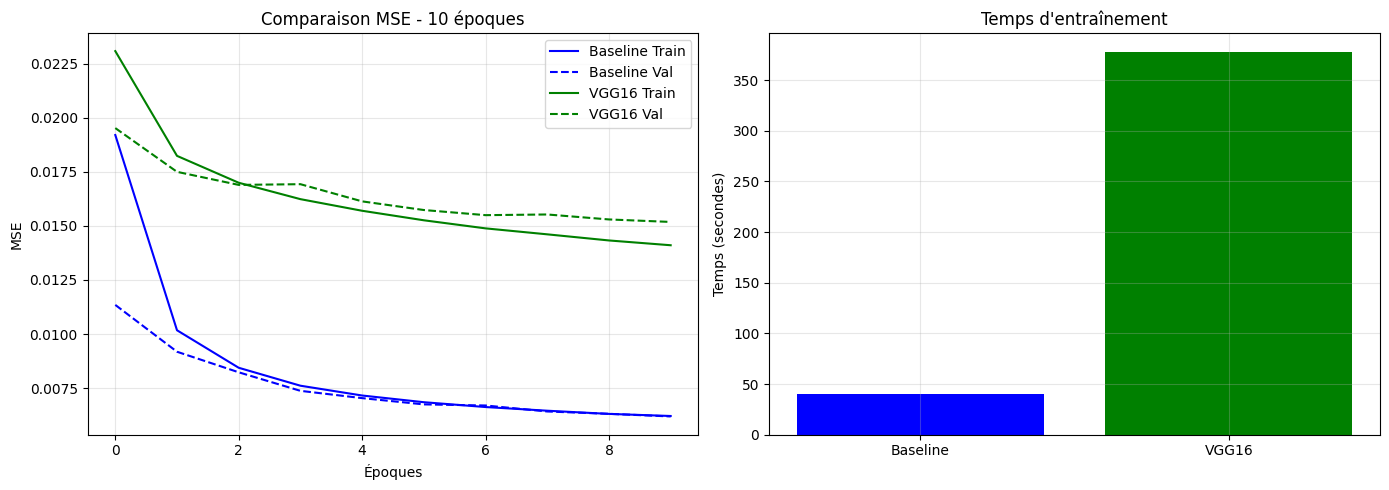

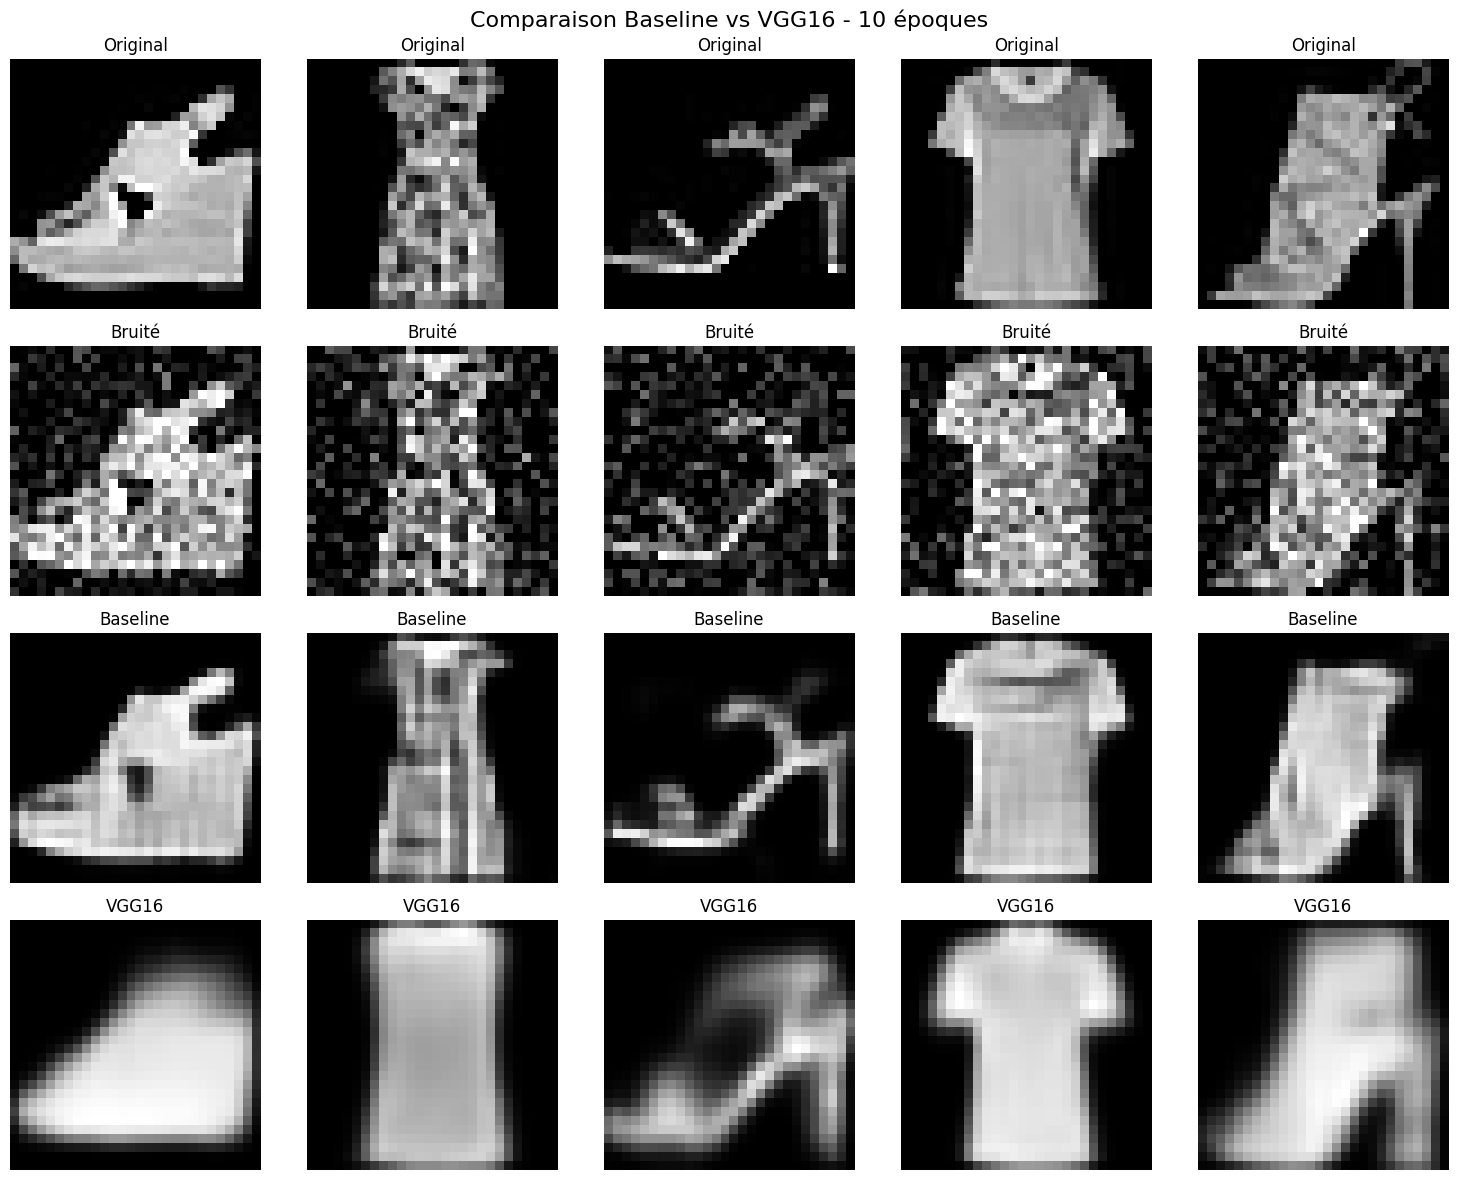


                             CONCLUSION - 10 ÉPOQUES                            
 Baseline : 0.8315 SSIM, 74K paramètres, 39.9s
 VGG16    : 0.6016 SSIM, 18.6M paramètres, 377.8s
 Gain SSIM: -27.65%
 Rapport  : VGG16 est 250x plus gros et 9.5x plus lent

 Le modèle Baseline est supérieur :
   • Meilleure qualité de reconstruction
   • 250x plus léger
   • 9.5x plus rapide

 VGG16 est sur-dimensionné pour Fashion MNIST


In [ ]:

# =====================================================
# 8. CONCLUSION
# =====================================================
print("\n" + "="*80)
print(" CONCLUSION - 10 ÉPOQUES".center(80))
print("="*80)

gain = (resultats[1][4] - resultats[0][4]) / resultats[0][4] * 100
ratio = (resultats[1][1] * 1000) / resultats[0][1]

print(f" Baseline : {resultats[0][4]:.4f} SSIM, {resultats[0][1]:.0f}K paramètres, {resultats[0][5]:.1f}s")
print(f" VGG16    : {resultats[1][4]:.4f} SSIM, {resultats[1][1]:.1f}M paramètres, {resultats[1][5]:.1f}s")
print(f" Gain SSIM: {gain:.2f}%")
print(f" Rapport  : VGG16 est {ratio:.0f}x plus gros et {resultats[1][5]/resultats[0][5]:.1f}x plus lent")

if resultats[0][4] > resultats[1][4]:
    print("\n Le modèle Baseline est supérieur :")
    print("   • Meilleure qualité de reconstruction")
    print("   • 250x plus léger")
    print(f"   • {resultats[1][5]/resultats[0][5]:.1f}x plus rapide")
    print("\n VGG16 est sur-dimensionné pour Fashion MNIST")
else:
    print("\n VGG16 apporte une légère amélioration mais au prix d'une complexité élevée")
print("="*80)